# Problem Description

Project Dataset from Kaggle - [dataset link](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

<b>Problem Statement</b>: 
Accurate time-series forecasting is crucial for optimizing inventory & supply chain management, reducing costs, and improving customer satisfaction in the highly competitive e-commerce industry. <br><br>

This project focuses on building a robust time series forecasting solution to predict <b><i>daily sales</i></b> for the E-commerce platform and <b><i>daily demand across multiple product categories</i></b>. <br><br> 

<i><b>How does daily sales and daily demand across multiple product categories help the business?</b></i> <br>
- Helps in resource & inventory optimization. Optimal stock levels reduces the risk of over-stocking or under-stocking.
- Effective-ness of Marketing Campaigns

<i><b>What business metrics do they relate to?</b></i> <br>
- Inventory Turnover Rate: Helps in evaluating how quickly inventory is sold and replaced, indicating the efficiency of inventory management.
- Customer Satisfaction Score (CSAT): Ensures product availability, leading to timely deliveries and enhanced customer satisfaction.
- Operational Costs: Assists in controlling costs related to storage, shipping, and handling by aligning inventory levels with demand.
- Stockout Rate: Accurate demand forecasting reduces the frequency of stockouts, ensuring products are available when customers want to purchase them.


Leveraging historical sales data, advanced forecasting models (ARIMA, SARIMA, SARIMAX, XGBoost), and engineered temporal features (lag, rolling statistics), the objective is to deliver actionable insights for demand planning and operational efficiency. The solution is designed to handle the dynamic nature of e-commerce sales, accounting for trends, seasonality, and external factors such as holidays.

# Import Packages

In [281]:
# !pip install holidays
# !pip install plotly
# !pip install pmdarima
# !pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 2.7 MB/s eta 0:00:00a 0:00:01


In [1]:
import os
import holidays
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from typing import Tuple

project_dir = Path(os.getcwd()).parent
data_dir = project_dir / 'data'

In [69]:
# CSV datasets from Kaggle
os.listdir(data_dir)

['olist_sellers_dataset.csv',
 '.DS_Store',
 'product_category_name_translation.csv',
 'olist_orders_dataset.csv',
 'olist_order_items_dataset.csv',
 'online_retail_II.csv',
 'olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_products_dataset.csv']

In [3]:
orders_df = pd.read_csv(data_dir / 'olist_orders_dataset.csv')
order_items_df = pd.read_csv(data_dir / 'olist_order_items_dataset.csv')

products_df = pd.read_csv(data_dir / 'olist_products_dataset.csv')
category_trans_df = pd.read_csv(data_dir / 'product_category_name_translation.csv')
products_df = products_df.merge(category_trans_df, on='product_category_name', how='left')

customers_df = pd.read_csv(data_dir / 'olist_customers_dataset.csv')
geolocation_df = pd.read_csv(data_dir / 'olist_geolocation_dataset.csv')

# Data Preprocessing

Only looking orders `delivered` to the customers.

In [4]:
orders_df = orders_df[orders_df['order_status'] == 'delivered'].drop(['order_status'], axis=1)

Join orders, order_item, and product datasets to get a holistic view of products and orders.

In [5]:
data_df = orders_df.merge(order_items_df, on='order_id').merge(products_df, on='product_id')[[
    'order_purchase_timestamp',
    'order_id',
    'seller_id',
    'product_id',
    'product_category_name_english',
    'order_item_id',
    'price',
    'freight_value',
]]

In [6]:
data_df = data_df.rename(columns={
    'order_purchase_timestamp': 'order_date',
    'product_category_name_english': 'product_category',
    'order_item_id': 'quantity'
})

Get the final price paid by the customer.

In [7]:
data_df['value'] = data_df['price'] + data_df['freight_value']
data_df['value'] = data_df['value'] * data_df['quantity']

In [8]:
data_df.drop(['price', 'freight_value', 'quantity'], axis=1, inplace=True)

Typecast string dates to datetime format.

In [9]:
data_df['order_date'] = pd.to_datetime(data_df['order_date'])

Some product categories are duplicate or represent the same thing. So we merge them for simplicity.

In [10]:
def merge_categories(cat: str):
    result = cat
    if cat == 'home_appliances_2':
        result = 'home_appliances'
    elif cat == 'home_comfort_2':
        result = 'home_comfort'
    elif cat == 'home_confort':
        result = 'home_comfort'
    return result

data_df['product_category'] = data_df['product_category'].apply(merge_categories)

In [11]:
data_df.dropna(inplace=True)

Add `holidays` column. Additionally marking `Black Friday` as a holiday. Having holiday information directly correlates with more demand and more sale in E-commerce industry.

In [12]:
br_holidays = holidays.country_holidays('BR', years=[2016, 2017, 2018], observed=False)

In [13]:
br_holidays[datetime(2017, 11, 24)] = 'Black Friday'

In [14]:
data_df['is_holiday'] = data_df['order_date'].apply(lambda x: 1 if x.date() in br_holidays else 0)

In [16]:
data_df.head()

,order_date,order_id,seller_id,product_id,product_category,value,is_holiday
0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,housewares,38.71,0
1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,perfumery,141.46,0
2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,auto,179.12,0
3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,72.20,0
4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,stationery,28.62,0


No null values!

In [17]:
data_df.isnull().sum()

order_date          0
order_id            0
seller_id           0
product_id          0
product_category    0
value               0
is_holiday          0
dtype: int64

In [18]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108638 entries, 0 to 110196
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   order_date        108638 non-null  datetime64[ns]
 1   order_id          108638 non-null  object        
 2   seller_id         108638 non-null  object        
 3   product_id        108638 non-null  object        
 4   product_category  108638 non-null  object        
 5   value             108638 non-null  float64       
 6   is_holiday        108638 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 6.6+ MB


# Daily Sales Forecast

In [100]:
sales_df = data_df[['order_date', 'is_holiday', 'value']] # selecting only the columns we need
sales_df.set_index('order_date', inplace=True) # setting the index to be the date

sales_df.rename({'value': 'sales'}, axis=1, inplace=True) # renaming the column to 'sales'

sales_df.sort_index(inplace=True) # sorting the dataframe by the index
sales_df = sales_df.resample('D').sum() # resample to daily sales

sales_df.dropna(inplace=True)

/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/1348213527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.rename({'value': 'sales'}, axis=1, inplace=True) # renaming the column to 'sales'
/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/1348213527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_df.sort_index(inplace=True) # sorting the dataframe by the index


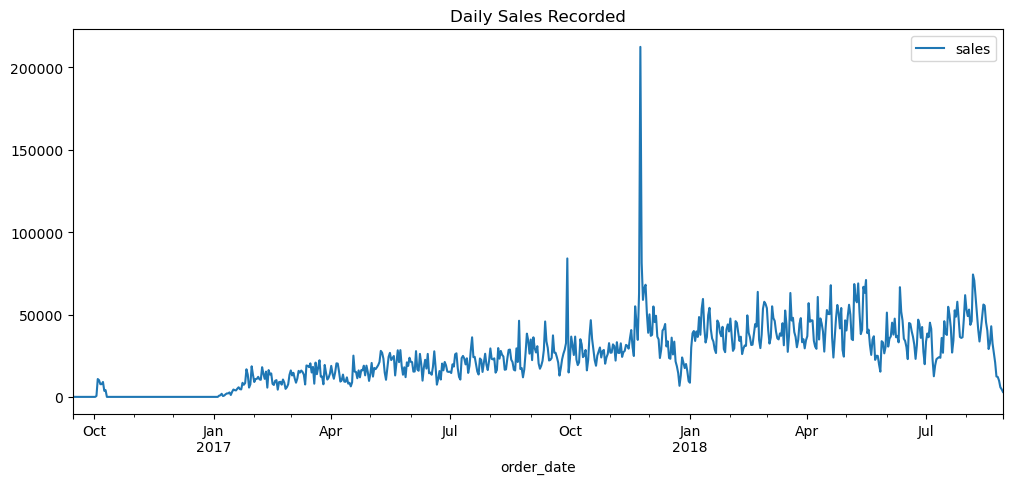

In [101]:
sales_df['sales'].plot(figsize=(12, 5))
plt.title(f'Daily Sales Recorded')
plt.legend()
plt.show()

- Dropping data for all the points from Oct 2016 to Jan 2017 as there isn't any recorded data.
- The day with Max Sales is 24th Nov 2017 - Black Friday (Outlier Event)
- There also appears a small trend and daily seasonality in sales.

Check Stationarity in the sales data using Augumented Dicky-fuller test.

In [22]:
def is_stationary(series: pd.Series, sig_level=0.05) -> bool:
    '''
    Perform Augmented Dickey-Fuller test to check if the series is stationary.
    If p-value is less than the significance level, we reject the null hypothesis and infer that the series is stationary.
    '''
    result = adfuller(series)
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return True if p_value < sig_level else False

In [74]:
print(f'Is Stationary: {is_stationary(sales_df["sales"])}')

ADF Statistic: -2.997036171230048
p-value: 0.03517211315481822
Is Stationary: True


The p-value < 0.05, which implies our data is stationary.

## ETS Decomposition

Check Trend and Seasonality in the sales data

In [24]:
decomposition = seasonal_decompose(sales_df['sales'], model='additive', period=7)

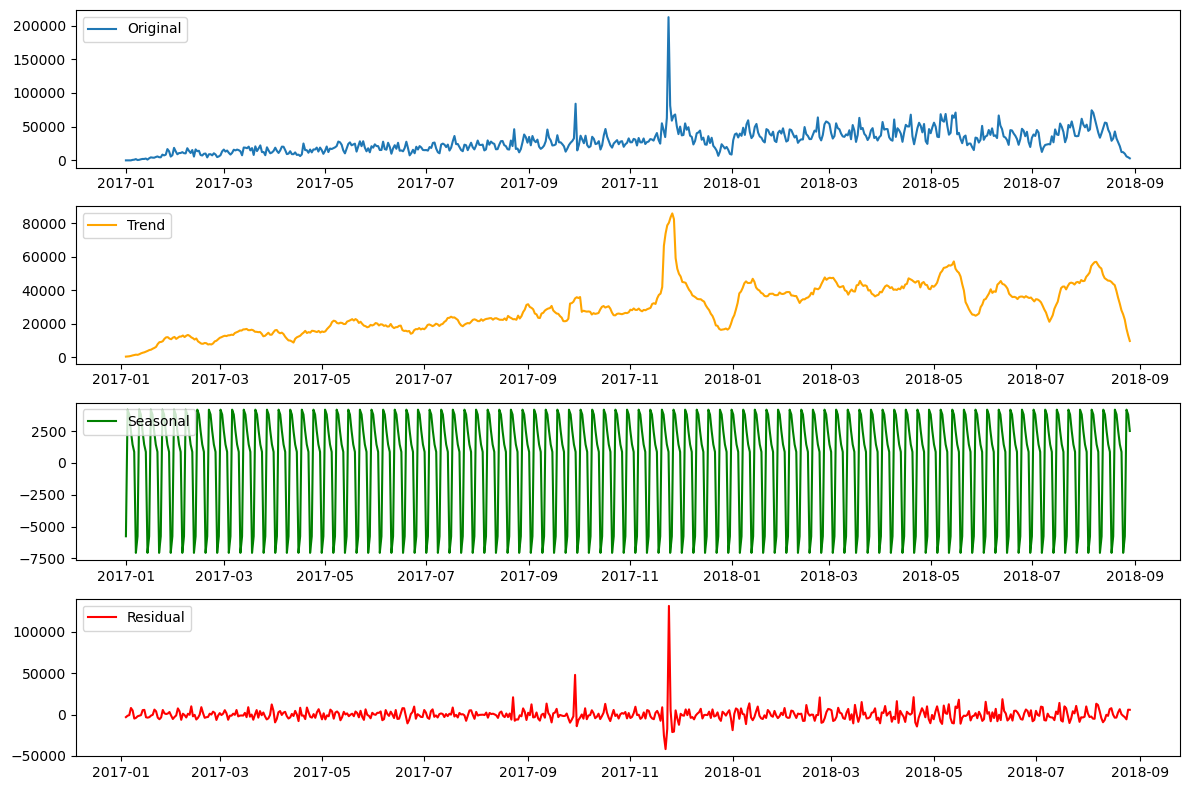

In [25]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(sales_df['sales'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

- There is a strong seasonality in the data. It is by every week.
- Trend is not strong but is present.

<Axes: xlabel='order_date'>

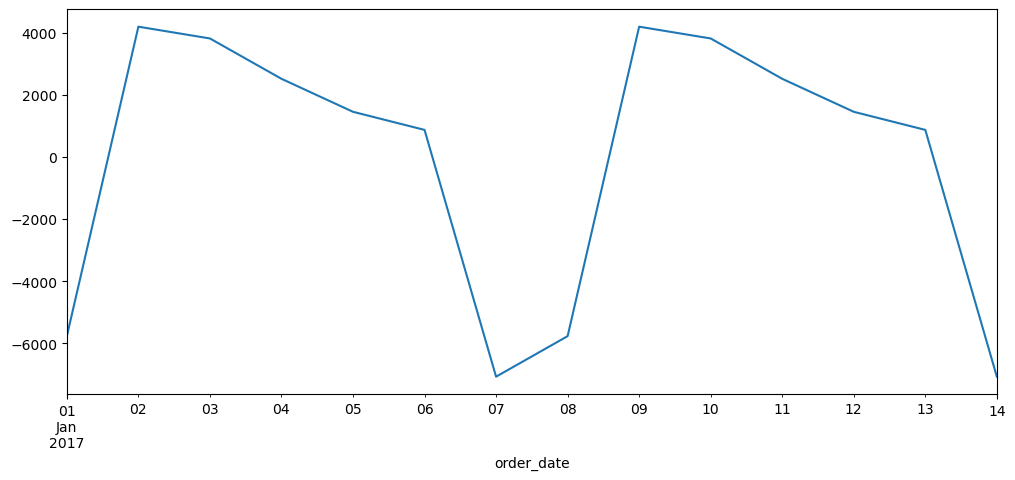

In [26]:
decomposition.seasonal[:14].plot(figsize=(12, 5))

Weekly Seasonality Observed.

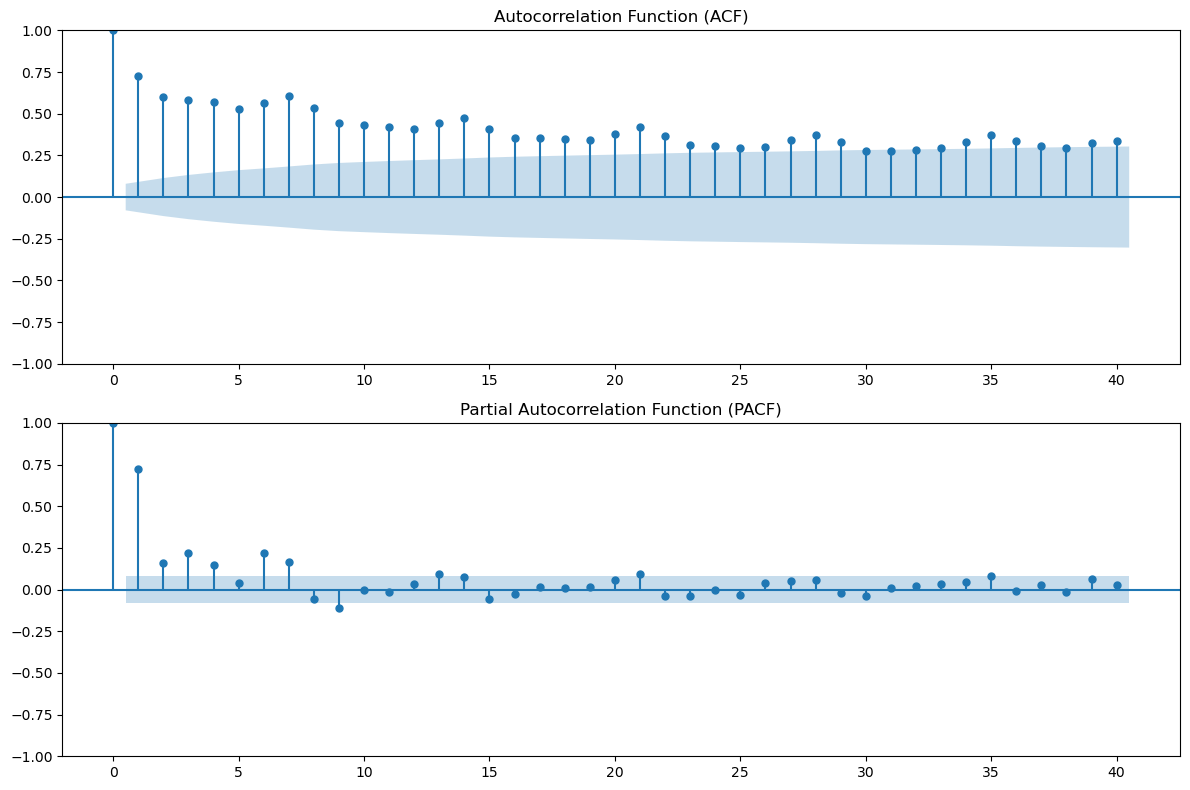

In [27]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, figsize=(12, 8))

# Autocorrelation Function (ACF)
plot_acf(sales_df['sales'], lags=40, ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF)')

# Partial Autocorrelation Function (PACF)
plot_pacf(sales_df['sales'], lags=40, ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

ACF and PACF plots show the correlation of a time series with its own previous values at time step T - 1, T - 2, T - 3, . . . T - n. These values help us in the Feature Engineering step to finalise the lags to include as Predictor Variables.<br>
- The ACF shows presences of strong seasonality.
- PACF tells us a max lag of 2 would be sufficient.

However, these plots can sometimes be complicated to infer from. Given we have a lot of compute we can make use of Auto-ARIMA to train multiple models and select the best one with Low AIC score. This way we can identify the right order of lags for AR and MA can be.

In [102]:
endog = sales_df['sales']
exog = sales_df[['is_holiday']]

<Axes: xlabel='order_date'>

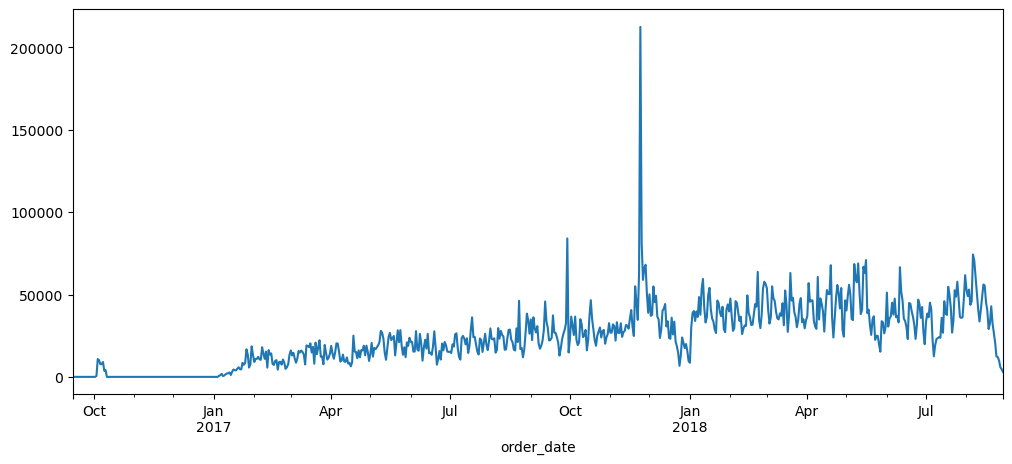

In [103]:
endog.plot(figsize=(12, 5))

In [104]:
is_stationary(endog)

ADF Statistic: -2.4596676170006204
p-value: 0.1255984903345851


False

## Training

In [105]:
train_size = int(len(endog) * 0.8)

# Data Split
endog_train, endog_test = endog[:train_size], endog[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

In [106]:
auto_model = auto_arima(endog_train,
                        exogenous=exog_train,
                        seasonal=True,
                        m=7,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(f'Optimal order: {auto_model.order}')
print(f'Optimal seasonal order: {auto_model.seasonal_order}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=12105.305, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=12279.864, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=12209.269, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=12132.089, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=12277.876, Time=0.00 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=12103.713, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=12116.103, Time=0.10 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=12103.326, Time=0.16 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=12104.114, Time=0.36 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=12105.323, Time=0.09 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=12105.656, Time=0.13 sec
 ARIMA(3,1,2)(1,0,0)[7] intercept   : AIC=12104.392, Time=0.25 sec
 ARIMA(2,1,3)(1,0,0)[7] interce

With the optimal order of AR, MA i.e p & q, let's train a SARIMAX model as we also have holiday as exogenous variable.

### SARIMAX

In [107]:
# Extract optimal parameters
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order

# Fit the SARIMAX model
sarimax_model = SARIMAX(endog_train,
                        exog=exog_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=True,
                        enforce_invertibility=False).fit()

# Print the model summary
print(sarimax_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03190D+01    |proj g|=  2.72988D-01

At iterate    5    f=  1.02974D+01    |proj g|=  3.47041D-02

At iterate   10    f=  1.02838D+01    |proj g|=  1.16508D-01


 This problem is unconstrained.



At iterate   15    f=  1.02666D+01    |proj g|=  3.75742D-01

At iterate   20    f=  1.02516D+01    |proj g|=  8.01571D-02

At iterate   25    f=  1.02501D+01    |proj g|=  2.74752D-02

At iterate   30    f=  1.02500D+01    |proj g|=  1.09906D-01

At iterate   35    f=  1.02463D+01    |proj g|=  4.47572D-01

At iterate   40    f=  1.02426D+01    |proj g|=  1.10401D-01

At iterate   45    f=  1.02423D+01    |proj g|=  8.49155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     68      1     0     0   3.473D-04   1.024D+01
  F =   10.242261517603826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Time to test the model!

In [108]:
# Forecast
n_forecast = len(endog_test)
forecast = sarimax_model.get_forecast(steps=n_forecast, exog=exog_test)

# Get confidence intervals
conf_int = forecast.conf_int()

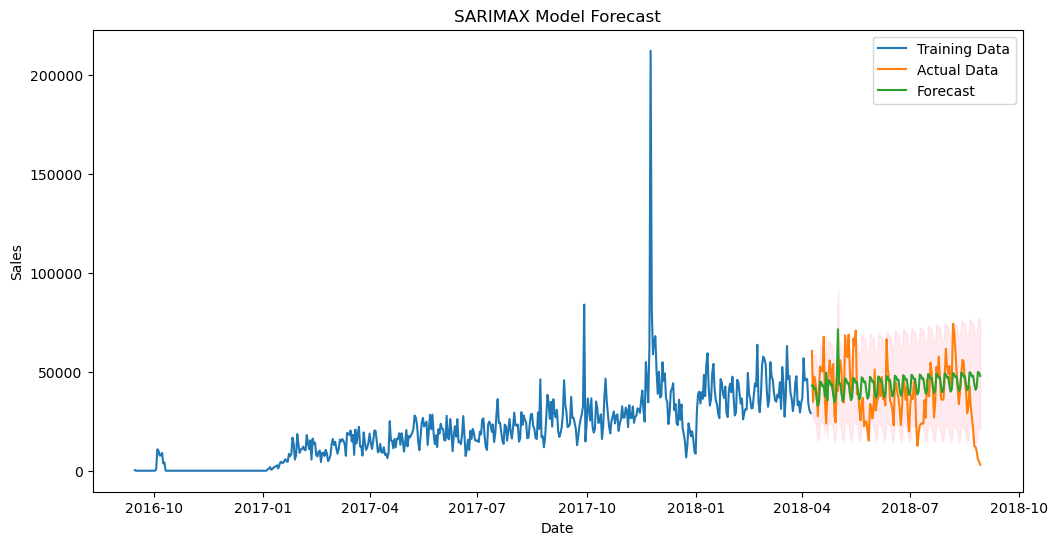

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(endog_train.index, endog_train, label='Training Data')
plt.plot(endog_test.index, endog_test, label='Actual Data')
plt.plot(endog_test.index, forecast.predicted_mean, label='Forecast')
plt.fill_between(endog_test.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('SARIMAX Model Forecast')
plt.legend()
plt.show()

In [110]:
mae = mean_absolute_error(endog_test, forecast.predicted_mean)
rmse = np.sqrt(mean_squared_error(endog_test, forecast.predicted_mean))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 11037.474053807216
Root Mean Squared Error: 14462.482713111955


Seems the model has learn't something close to test data but it is not very accurate. Let's try a Machine Learning Approach by training XGBoost model.

### XGBoost

So the optimal order of AR is 2, so we will include two lags. For MA, it is 2 and so a rolling average of 2 is used. Finally no differencing.

In [126]:
# Feature Engineering:

# Lag Features - AR part
sales_df['lag_1'] = sales_df['sales'].shift(1)
sales_df['lag_2'] = sales_df['sales'].shift(2)

# Rolling Statistics Features - MA part
sales_df['rolling_mean_2'] = sales_df['sales'].rolling(window=2).mean()

# Additional Features
sales_df['day_of_week'] = sales_df.index.dayofweek
sales_df['month'] = sales_df.index.month
sales_df['is_holiday'] = sales_df['is_holiday']

In [127]:
sales_features = sales_df.dropna()

In [128]:
X = sales_features[['lag_1', 'lag_2', 'rolling_mean_2', 'day_of_week', 'month', 'is_holiday']]
y = sales_features['sales']

In [129]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [130]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 3303.634988896888


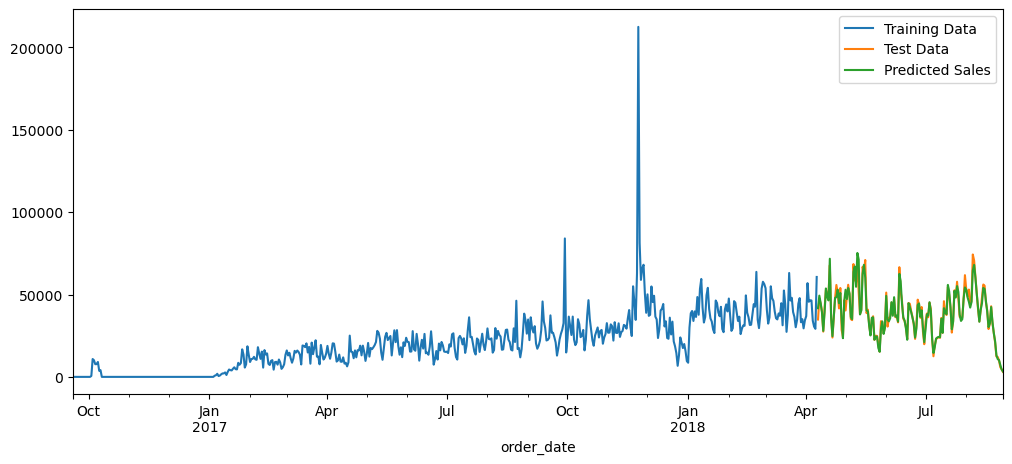

In [131]:
sales_df.loc[X_train.index]['sales'].plot(figsize=(12, 5), label='Training Data')
sales_df.loc[X_test.index]['sales'].plot(label='Test Data')
pd.Series(y_pred, index=y_test.index).plot(figsize=(12, 5), label='Predicted Sales')
plt.legend()
plt.show()

Wow. When compared with SARIMAX, the XGBoost forecasts are much accurate. <br>The SARIMAX estimates are off by 14,000! However the XGBoost forecasts are only off by 3000!

# Demand Forecasting across Product Categories

In [132]:
x = data_df.reset_index().rename({'order_date': 'order_ts'}, axis=1)
x['order_date'] = x['order_ts'].dt.date

In [133]:
x.head()

,index,order_ts,order_id,seller_id,product_id,product_category,value,is_holiday,order_date
0,0,2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,3504c0cb71d7fa48d967e0e4c94d59d9,87285b34884572647811a353c7ac498a,housewares,38.71,0,2017-10-02
1,1,2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,289cdb325fb7e7f891c38608bf9e0962,595fac2a385ac33a80bd5114aec74eb8,perfumery,141.46,0,2018-07-24
2,2,2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,4869f7a5dfa277a7dca6462dcf3b52b2,aa4383b373c6aca5d8797843e5594415,auto,179.12,0,2018-08-08
3,3,2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,66922902710d126a0e7d26b0e3805106,d0b61bfb1de832b15ba9d266ca96e5b0,pet_shop,72.20,0,2017-11-18
4,4,2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,2c9e548be18521d1c43cde1c582c6de8,65266b2da20d04dbe00c5c2d3bb7859e,stationery,28.62,0,2018-02-13


The `size` aggregation function in a groupby will count the number of orders from each product category on a specific day. This count will be the demand we want to model.

In [134]:
category_demand = x.groupby(['order_date', 'product_category', 'is_holiday']).size().reset_index().rename({0: 'demand'}, axis=1)
category_demand['order_date'] = pd.to_datetime(category_demand['order_date'])

In [135]:
category_demand.set_index('order_date', inplace=True)

Drop the categories less than 50 records - hard to compute with less data

In [136]:
x = category_demand['product_category'].value_counts().reset_index()
x = x[x['count'] > 50]
useful_categories = x['product_category'].to_list()
print(f'Number of categories: {len(useful_categories)}')

Number of categories: 56


In [137]:
category_demand = category_demand[category_demand['product_category'].isin(useful_categories)]

In [138]:
category_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17859 entries, 2016-09-15 to 2018-08-29
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_category  17859 non-null  object
 1   is_holiday        17859 non-null  int64 
 2   demand            17859 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 558.1+ KB


We have a time-series for each of the product category. We have two options for modelling this. Either build multiple individual local models for each product category or build one global model for all the product categories. I choose to train one global model as it is easy to maintain and serve in production than maintaining and deploying a single model for each product category. <br><br> To train a global model, we need the dataset to be present in a specific format. Index should be a DateTime Index and each column should represent a product category time series. So we build a `pivot` table for this.

In [52]:
category_tab_df = pd.pivot_table(category_demand, index=category_demand.index, columns='product_category', values='demand', aggfunc='sum')

In [53]:
category_tab_df['is_holiday'] = category_demand[~category_demand.index.duplicated()]['is_holiday']

In [54]:
category_tab_df.fillna(0, inplace=True)

Resampling for every Day

In [55]:
category_tab_df = category_tab_df.resample('D').sum()

In [56]:
category_tab_df.head()

product_category,agro_industry_and_commerce,air_conditioning,art,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts,is_holiday
order_date,,,,,,,,,,,,,,,,,,,,,
2016-09-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-09-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [57]:
category_tab_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 714 entries, 2016-09-15 to 2018-08-29
Freq: D
Data columns (total 57 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   agro_industry_and_commerce               714 non-null    float64
 1   air_conditioning                         714 non-null    float64
 2   art                                      714 non-null    float64
 3   audio                                    714 non-null    float64
 4   auto                                     714 non-null    float64
 5   baby                                     714 non-null    float64
 6   bed_bath_table                           714 non-null    float64
 7   books_general_interest                   714 non-null    float64
 8   books_technical                          714 non-null    float64
 9   christmas_supplies                       714 non-null    float64
 10  cine_photo             

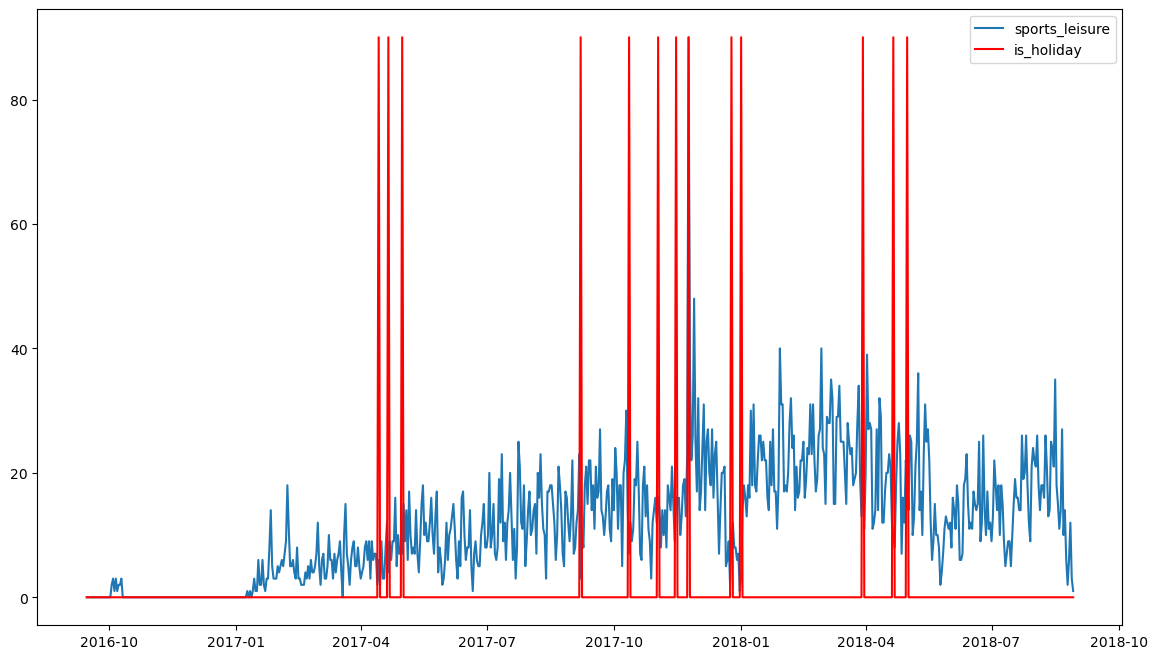

In [58]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(category_tab_df['sports_leisure'], label='sports_leisure')
ax.plot(category_tab_df['is_holiday']*category_tab_df['sports_leisure'].max(), color='red', label='is_holiday')
plt.legend()
plt.show()

In [59]:
def adf_test(series: pd.Series):
    result = adfuller(series)
    p_value = result[1]
    return p_value

Checking the stationarity of each product category time series

In [60]:
for cat in category_tab_df.columns[:-1]:
    p_value = adf_test(category_tab_df[cat])
    print(f'{cat}: {p_value} | is_stationary: {p_value < 0.05}')

agro_industry_and_commerce: 0.0031052690470654907 | is_stationary: True
air_conditioning: 6.368715658436334e-09 | is_stationary: True
art: 0.03091760694462532 | is_stationary: True
audio: 0.002027495367938095 | is_stationary: True
auto: 0.2474826423221414 | is_stationary: False
baby: 0.12226866721528906 | is_stationary: False
bed_bath_table: 0.004587275045390161 | is_stationary: True
books_general_interest: 0.023074912593321263 | is_stationary: True
books_technical: 0.08894886157780885 | is_stationary: False
christmas_supplies: 0.03590477046132949 | is_stationary: True
cine_photo: 7.111350438692955e-07 | is_stationary: True
computers: 1.2314739851479163e-07 | is_stationary: True
computers_accessories: 0.26136716584346176 | is_stationary: False
consoles_games: 0.0006356400411409399 | is_stationary: True
construction_tools_construction: 0.6837633037271924 | is_stationary: False
construction_tools_lights: 0.5770638033361829 | is_stationary: False
construction_tools_safety: 0.1049631859559

Building Lags and Rolling Statistics for each category and using them as features.

In [61]:
def feature_engineering(
        data: pd.DataFrame, p: int, q: int, 
        day_of_week: bool = True, 
        month: bool = True, 
        is_weekend: bool = True,
        test_size: float = 0.2
        ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Create Time Series Features for Model Training. Asssumption is that the data is indexed by date.
    :param p: Number of lags to include
    :param q: Window size for rolling mean
    '''
    df = data.copy(deep=True)
    prod_categories = df.columns[:-1]

    if day_of_week:
        df['day_of_week'] = df.index.dayofweek
    if month:
        df['month'] = df.index.month
    if is_weekend:
        df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    for cat in prod_categories:
        for lag in range(1, p + 1):
            df[f'{cat}_lag_{lag}'] = df[cat].shift(lag)

        df[f'{cat}_rolling_mean_{q}'] = df[cat].rolling(window=q).mean()
    
    df.dropna(inplace=True)

    X = df.drop(prod_categories, axis=1)
    y = df[prod_categories]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    return X_train, X_test, y_train, y_test

In [140]:
X_train, X_test, y_train, y_test = feature_engineering(data=category_tab_df, p=2, q=2)

/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/688120137.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{cat}_rolling_mean_{q}'] = df[cat].rolling(window=q).mean()
/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/688120137.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{cat}_lag_{lag}'] = df[cat].shift(lag)
/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/688120137.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

We have 172 predictors (in total) and 569 time samples.

In [141]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 569 entries, 2016-09-17 to 2018-04-08
Freq: D
Columns: 172 entries, is_holiday to watches_gifts_rolling_mean_2
dtypes: float64(168), int32(2), int64(2)
memory usage: 764.6 KB


In [142]:
model = XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [143]:
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.7531200230539439


Forecasting for next 7 days

In [144]:
n_steps = 7
recent_data = X_train.tail(1).copy(deep=True)
prediction_columns = y_train.columns
forecast = pd.DataFrame(columns=prediction_columns)

for i in range(n_steps):
    prev_day = recent_data.tail(1)
    prev_day_data = prev_day.values.reshape(1, -1)
    prev_date = prev_day.index[0]

    prediction_value = model.predict(prev_day_data)
    prediction_date = prev_date + pd.DateOffset(days=1)
    prediction_row = pd.DataFrame(prediction_value, index=[prediction_date], columns=prediction_columns)
    forecast = pd.concat([forecast, prediction_row], axis=0)

    new_rec = {i: 0 for i in prev_day.columns}
    new_rec['day_of_week'] = prediction_date.dayofweek
    new_rec['month'] = prediction_date.month
    new_rec['is_weekend'] = 1 if new_rec['day_of_week'] >= 5 else 0

    # prev day's lag 1 is new rec's lag 2
    for cat in prediction_columns:
        new_rec[f'{cat}_lag_2'] = prev_day[f'{cat}_lag_1'].values[0]
        new_rec[f'{cat}_lag_1'] = prediction_row.iloc[0][cat]
        new_rec[f'{cat}_rolling_mean_2'] = np.mean([new_rec[f'{cat}_lag_2'], new_rec[f'{cat}_lag_1']])
    
    recent_data = pd.concat([recent_data, pd.DataFrame(new_rec, index=[prediction_date])], axis=0)

/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/2444214171.py:14: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  forecast = pd.concat([forecast, prediction_row], axis=0)
/var/folders/ls/0ww7r56d4tv_rngzynr496400000gn/T/ipykernel_9665/2444214171.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecast = pd.concat([forecast, prediction_row], axis=0)


In [145]:
forecast

product_category,agro_industry_and_commerce,air_conditioning,art,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,pet_shop,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
2018-04-09,0.000185,0.000125,1.997378,0.000257,4.968965,6.986967,30.025318,0.999284,-0.000017,0.000141,...,4.002950,0.000111,3.998707,0.000058,14.257848,0.025041,0.000079,4.997171,2.995108,9.766434
2018-04-10,0.000168,0.000125,0.000617,0.000302,10.755862,3.991482,22.986111,0.998598,-0.000510,0.000141,...,4.051684,0.000111,3.893015,0.000058,12.674479,-0.036762,0.000076,7.856422,4.065028,9.022528
2018-04-11,0.000185,0.000125,0.998914,0.000302,4.836846,7.142305,30.751961,0.998387,-0.000038,0.000141,...,4.070055,0.000111,2.936997,0.000058,14.447546,0.018266,0.000076,4.906593,2.988848,9.128006
2018-04-12,0.000168,0.000125,0.000147,0.000302,11.169631,3.984739,23.416431,0.998598,0.000043,0.000141,...,4.068718,0.000111,4.108199,0.000054,14.676768,-0.008338,0.000076,7.821665,4.967858,9.060717
2018-04-13,0.000185,0.000125,0.000147,0.000302,4.964489,7.972400,31.700312,0.998387,-0.000038,0.000141,...,4.070055,0.000111,2.367194,0.000058,15.154758,0.015623,0.000076,4.906593,2.988848,9.074440
2018-04-14,0.000168,0.000125,0.000147,0.000302,12.601294,3.982289,26.072994,0.998598,0.000043,0.000141,...,4.067242,0.000111,4.796292,0.000054,12.681280,-0.010593,0.000076,7.821665,5.035355,9.078747
2018-04-15,0.000185,0.000125,0.000147,0.000302,5.582227,7.970403,29.858868,0.998387,-0.000038,0.000141,...,4.070055,0.000111,2.370243,0.000058,15.792739,0.019328,0.000076,4.906593,2.837523,9.083116


In [146]:
y_test.loc[forecast.index]

product_category,agro_industry_and_commerce,air_conditioning,art,audio,auto,baby,bed_bath_table,books_general_interest,books_technical,christmas_supplies,...,pet_shop,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
2018-04-09,0.0,0.0,1.0,3.0,21.0,13.0,23.0,0.0,1.0,0.0,...,8.0,7.0,1.0,0.0,27.0,6.0,0.0,8.0,3.0,9.0
2018-04-10,0.0,1.0,1.0,1.0,9.0,12.0,19.0,0.0,0.0,0.0,...,9.0,0.0,1.0,2.0,14.0,1.0,0.0,2.0,4.0,13.0
2018-04-11,0.0,0.0,0.0,4.0,14.0,9.0,34.0,0.0,0.0,0.0,...,6.0,0.0,5.0,0.0,32.0,4.0,0.0,12.0,4.0,12.0
2018-04-12,1.0,0.0,1.0,0.0,13.0,4.0,32.0,5.0,1.0,1.0,...,5.0,4.0,5.0,1.0,29.0,6.0,0.0,26.0,5.0,10.0
2018-04-13,1.0,1.0,0.0,0.0,11.0,7.0,30.0,1.0,1.0,0.0,...,5.0,0.0,1.0,0.0,12.0,7.0,0.0,6.0,7.0,12.0
2018-04-14,0.0,0.0,0.0,1.0,7.0,7.0,17.0,0.0,0.0,0.0,...,3.0,2.0,5.0,0.0,12.0,3.0,0.0,6.0,1.0,11.0
2018-04-15,0.0,2.0,1.0,1.0,12.0,13.0,24.0,0.0,0.0,0.0,...,3.0,0.0,2.0,0.0,17.0,11.0,0.0,11.0,3.0,7.0


In [150]:
category_wise_rmse = {}

expected = y_test.loc[forecast.index]
for cat in forecast.columns:
    category_wise_rmse[cat] = np.sqrt(mean_squared_error(expected[cat], forecast[cat]))

In [160]:
sorted(category_wise_rmse.items(), key=lambda x: x[1], reverse=True)

[('sports_leisure', 9.92282490034675),
 ('furniture_decor', 9.28815988112212),
 ('housewares', 8.582231428292086),
 ('telephony', 8.156737491824304),
 ('auto', 8.074478912668367),
 ('computers_accessories', 7.288585959122766),
 ('health_beauty', 7.03815392256089),
 ('bed_bath_table', 6.199172709944298),
 ('stationery', 6.177721461559922),
 ('electronics', 5.364849629367309),
 ('cool_stuff', 5.246866105370808),
 ('home_appliances', 5.051125766051152),
 ('office_furniture', 5.003840081765934),
 ('baby', 4.45762876159166),
 ('drinks', 4.070885586679293),
 ('home_construction', 3.6433904605875425),
 ('fashion_bags_accessories', 3.601448241503616),
 ('signaling_and_security', 3.1395428357740003),
 ('construction_tools_lights', 2.9279479123548082),
 ('construction_tools_construction', 2.8727610957236616),
 ('perfumery', 2.8250746599810017),
 ('pet_shop', 2.6241470061008614),
 ('garden_tools', 2.5683136427383553),
 ('watches_gifts', 2.453213494824582),
 ('toys', 2.185260575915814),
 ('audio',

In [147]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.7531200230539439
